# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [51]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
import numpy as np
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [52]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from copy import deepcopy

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Bidirectional LSTM with dropout layer

After watching CS224N lecture videos and learning about RNN, LSTM and BILSTM architectures, I implemented my own architecture. <br>
The architecture consists of 6 Bi-LSTM layers, one dropout layer and fully connected layer at the end. <br> The graph for LSTM architecture and simplified Bi-LSTM graph are represented on figures below.
<br> After creating a model I experimented with different parameters batch_size, embedding_dim, hidden_size, num_epochs.
<br> The final achieved accuracy on the set of 1000 unseen words is 61.6%



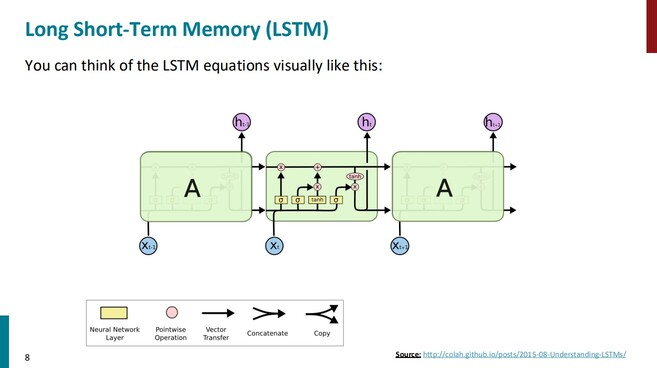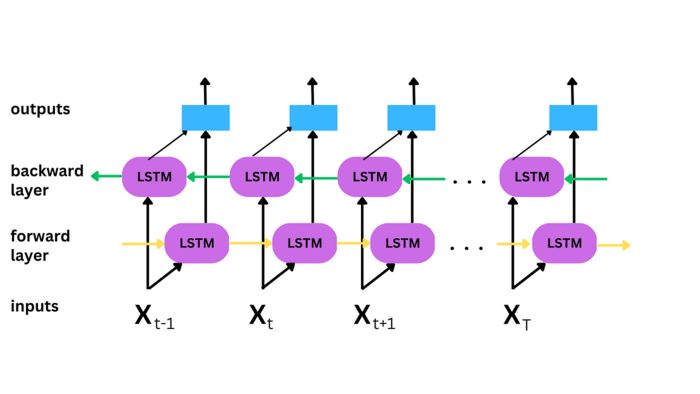

In [54]:
embedding_dim = 256
num_classes = 26
learning_rate = 0.001
hidden_size = 128
batch_size = 3000
num_epochs = 12
input_size = 256
class BLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BLSTM, self).__init__()

        self.embedding = nn.Embedding(28, embedding_dim, padding_idx=0)    # if padding_idx is specified the values do not contribute to the gradient
        # num_embeddings (int) – size of the dictionary of embeddings
        # embedding_dim (int) – the size of each embedding vector

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm5 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm6 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size * 2, num_classes)



    def forward(self, x):
        x = self.embedding(x)                # each token in sequence ('abc0_') is represented by 256 dimensional vector
        x, (h_1, c_1) = self.lstm1(x)       # input x is of shape batch_size, sequence length, embedding_dim
        x, (h_2, c_2) = self.lstm2(x, (h_1,c_1))  # pass hidden state and cell state to the next layer as inputs
        x, (h_3, c_3) = self.lstm3(x, (h_2,c_2))
        x, (h_4, c_4) = self.lstm4(x, (h_3,c_3))
        x, (h_5, c_5) = self.lstm5(x, (h_4,c_4))
        x, (h_6, c_6) = self.lstm6(x, (h_5,c_5))
        
        # x is output of shape (batch_size,sequence length,2*hidden_size)
        
        x = self.dropout(x[:,-1,:])    # x[:,-1,:] is of shape (batch_size, 2*hidden_size) this corresponds to prediction of letter(token) for each sample in batch
        out = self.fc(x)               # this creates matrix of (batch_size, num_classes) with raw scores for each letter
        return out

# Dropout layer, during training, randomly zeroes some of the elements of the input tensor with probability p to prevent overfitting.


In [55]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        self.device = device
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        self.max_length = 0
        self.test_size = 0.1
        self.batch_size = batch_size
        self.current_dictionary = []
        self.train_model()   # call a function for training a model
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word): # word input example: "_ p p _ e "
        self.model.eval()
        clean_word = word.replace(" ","")
        encoded = self.encode_word(clean_word)

        while len(encoded) < self.max_length:
            encoded.append(0)

        x = torch.tensor([encoded], dtype=torch.long).to(self.device)
        with torch.no_grad():
            output = self.model(x)  # shape (1, 26)
            probs = F.softmax(output[0], dim=0)  # shape (26,)
    
        
        sorted_indices = torch.argsort(probs, descending=True)
        pred_letters = []
        for i in sorted_indices:
            letter = chr(ord('a') + i.item())   # .item() returns the value of this tensor as a standard Python number
            pred_letters.append(letter)   


        for letter in pred_letters:                 
                if letter not in self.guessed_letters:
                    return letter
   
    def encode_word(self, word):    # _abc -> 27, 1, 2, 3
        encoded_word = []
        for cha in word:
            if ord(cha) == ord("_"):
                encoded_word.append(27)
            else:
                encoded_word.append(ord(cha)- ord("a")+1)
        return encoded_word
    
    def check_accuracy(self, loader, k=5):
        num_correct_top1 = 0
        num_correct_topk = 0
        num_samples = 0
        self.model.eval()
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                scores = self.model(x)  # shape (batch_size, 26)
                _, top1_pred = scores.max(1)   # outputs (max, max_indices)  
                num_correct_top1 += (top1_pred == y).sum().item()     # check if it is the same letter as ground truth
    
                # Top k letter accuracy
                # torch.topk returns the k largest elements of the given input tensor along a given dimension.
                topk_pred = torch.topk(scores, k, dim=1).indices  # (batch_size, k)   
                y_expanded = y.view(-1, 1).expand_as(topk_pred)          # (batch_size, k)
                
                # .any tests if any element in input evaluates to true
                num_correct_topk += (topk_pred == y_expanded).any(dim=1).sum().item()  
    
                num_samples += y.size(0)
    
        print(f"First letter accuracy: {num_correct_top1 / num_samples:.2%}")  # Accuracy that the letter with hihgest prob score is the same as ground truth
        print(f"Top-{k} accuracy: {num_correct_topk / num_samples:.2%}")   # the ground truth letter is in the 5 letters with highest probability scores

            
        
    def train_model(self):
        model = BLSTM(input_size, hidden_size, num_classes).to(device)
        self.model = model
        X, y = self.prepare_data()
        self.max_length = X.shape[1]


        dataset = torch.utils.data.TensorDataset(X, y)
        train_size = int((1 - self.test_size) * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # train_loader makes batches of (batch_size, max_seq_len) for inputs and (batch_size,) for targets
        
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
                
        # Loss and optimizer
        loss_fcn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        
        
        
        
        # Train a network
        
        for epoch in range(num_epochs):
            model.train()
            print(f"Epoch: {epoch+1} ")
            for batch_index, (data,targets) in enumerate(train_loader):    
                data = data.to(device = self.device)
                targets = targets.to(device = self.device)
        
                # forward pass
                scores = model(data)
                loss = loss_fcn(scores, targets)
        
                # backward pass
                optimizer.zero_grad()
                loss.backward()
        
                # update parameters
                optimizer.step()
            self.check_accuracy(test_loader)  # after each epoch check accuracies
    def prepare_data(self):

        # Data set preparation
        
        encoded_dictionary = [self.encode_word(word) for word in self.full_dictionary]   # encode each word in dictionary
        X, y = [], []
    
        for encoded_word in encoded_dictionary:
            char_positions = {c: [] for c in set(encoded_word)}   # map each char to a positions in a word
            for i, c in enumerate(encoded_word):
                char_positions[c].append(i)
    
            char_list = list(char_positions.keys())
            for cha, positions in char_positions.items():
                masked_word = deepcopy(encoded_word)
                for pos in positions:
                    masked_word[pos] = 27  # Token for mask (_)
                target = cha - 1 


                # Mask each unique letter and create initial masked variants of encoded word
                
                X.append(masked_word)
                y.append(target)
    
                # Additional masked variants
                seen = {cha}
                new_masked_word = deepcopy(masked_word)
                for _ in range(len(char_list)):
                    other_char = random.choice(char_list)   # pick random letter from char_list that has not been previously masked
                    if other_char in seen:
                        continue 
                    seen.add(other_char)
                    for pos in char_positions[other_char]:
                        new_masked_word[pos] = 27
                    X.append(deepcopy(new_masked_word))
                    y.append(target)   # the target remains the same
    
        maxlen = 0
        for x in X:
            if len(x) > maxlen:
                maxlen = len(x)
        for i in range(len(X)):
            padding = [0] * (maxlen - len(X[i]))
            X[i] = X[i] + padding

        print('Dataset preparation status: done')
        return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

            

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [56]:
api = HangmanAPI(access_token="fcd4e1d3d86e443e9fb865f88871de",  timeout=2000)


Dataset preparation status: done
Epoch: 1 
First letter accuracy: 29.35%
Top-5 accuracy: 71.35%
Epoch: 2 
First letter accuracy: 30.79%
Top-5 accuracy: 73.04%
Epoch: 3 
First letter accuracy: 31.65%
Top-5 accuracy: 73.98%
Epoch: 4 
First letter accuracy: 32.11%
Top-5 accuracy: 74.57%
Epoch: 5 
First letter accuracy: 32.48%
Top-5 accuracy: 75.01%
Epoch: 6 
First letter accuracy: 32.73%
Top-5 accuracy: 75.27%
Epoch: 7 
First letter accuracy: 32.89%
Top-5 accuracy: 75.47%
Epoch: 8 
First letter accuracy: 33.08%
Top-5 accuracy: 75.66%
Epoch: 9 
First letter accuracy: 33.08%
Top-5 accuracy: 75.73%
Epoch: 10 
First letter accuracy: 33.23%
Top-5 accuracy: 75.86%
Epoch: 11 
First letter accuracy: 33.30%
Top-5 accuracy: 75.93%
Epoch: 12 
First letter accuracy: 33.32%
Top-5 accuracy: 75.92%


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [50]:
success = 0
unsuccess = 0


for i in range(1000):
    api.start_game(practice=1,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
    practice_success_rate = total_practice_successes / total_practice_runs
    print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))
print(total_practice_successes)

Successfully start a new game! Game ID: 9d3b12580795. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '9d3b12580795', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ e _ e _ '}
Guessing letter: r
Sever response: {'game_id': '9d3b12580795', 'status': 'ongoing', 'tries_remains': 6, 'word': 'r e _ r _ e r e _ '}
Guessing letter: d
Sever response: {'game_id': '9d3b12580795', 'status': 'ongoing', 'tries_remains': 6, 'word': 'r e _ r d e r e d '}
Guessing letter: o
Sever response: {'game_id': '9d3b12580795', 'status': 'success', 'tries_remains': 6, 'word': 'r e o r d e r e d '}
Successfully finished game: 9d3b12580795
run 4778 practice games out of an allotted 100,000. practice success rate so far = 0.594
Successfully start a new game! Game ID: 363a3f337dc9. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '363a3f337dc9', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ '

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [57]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [58]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.616
